In [28]:
import torch
from torch.utils.data.dataloader import DataLoader as dl
from torch.utils.data import TensorDataset as ds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [29]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda:0


In [30]:
class MLP(torch.nn.Module): 
    def __init__(self):
        super(MLP,self).__init__()
        self.fc1 = torch.nn.Linear(1,80) 
        self.activation1 = torch.nn.ReLU() 
        self.fc2 = torch.nn.Linear(80,1)
        #self.fc3 = torch.nn.Linear(40,1) 

    def forward(self, x): 
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        # x = self.activation1(x)
        # x = self.fc3(x)
        return x

net = MLP()
net.to(device)
print(net) 

MLP(
  (fc1): Linear(in_features=1, out_features=80, bias=True)
  (activation1): ReLU()
  (fc2): Linear(in_features=80, out_features=1, bias=True)
)


In [31]:
datapoints = 200
split_size = 0.9
noise_level =.01
x = torch.randint(-50,50,(datapoints,1)).float()
noise = torch.randn((datapoints,1))
y = (x**2)+(2*x)+ 3 
xavg = x.mean()
xdev = x.std()
yavg = y.mean()
ydev = y.std()
x = (x-xavg)/xdev
y = (y-yavg)/ydev
print(y.shape,noise.shape)
y = y+(noise*noise_level)
# for i in range(len(y)):
#     y[i] = y[i] + noise[i]

torch.Size([200, 1]) torch.Size([200, 1])


In [32]:
print(x.shape)
print(y.shape)

torch.Size([200, 1])
torch.Size([200, 1])


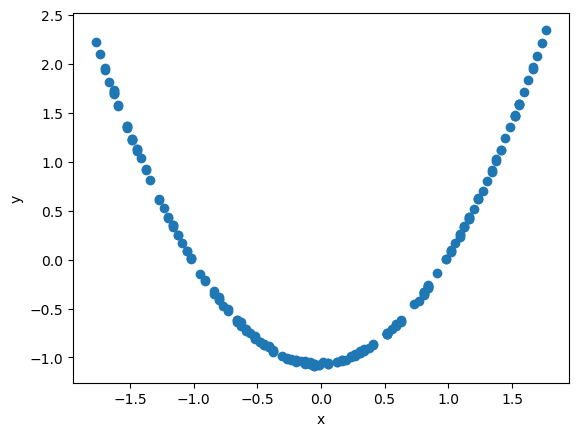

In [33]:

plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [34]:
xtrain, ytrain = x[:int(split_size*datapoints)],y[:int(split_size*datapoints)] 
xtest, ytest = x[int(split_size*datapoints):],y[int(split_size*datapoints):]


xtrain, xval, ytrain,yval = train_test_split(xtrain,ytrain,test_size=0.1,random_state=9,shuffle=True)

trainingset = ds(xtrain,ytrain)
testset = ds(xtest,ytest)
validationset = ds(xval,yval)

trainloader = dl(trainingset,num_workers=16,shuffle=True,batch_size=32)
testloader = dl(testset,num_workers=16,shuffle=False,batch_size=32)
validationloader = dl(validationset,num_workers=16,shuffle=False,batch_size=32)

In [35]:
criteria = torch.nn.MSELoss()
optim = torch.optim.Adam(net.parameters(),lr=0.001)

In [36]:
def train_model(model,criteria,optimizer,dataloader,validation_set_loader,number_epochs:int):
    epochs = []
    training_loss_per_epoch = []
    training_loss_per_batch = []
    validation_loss_per_epoch = []
    validation_loss_per_batch = []
    y_values_for_last_batch=[]
    x_values_for_last_batch=[]
    for epoch in range(number_epochs):
        print(f'epoch number: {epoch}')
        model.train()
        training_losses = []
        for data,label in dataloader:
            optimizer.zero_grad()
            data = data.to(device)
            label = label.to(device)
            outputs = model(data)
            loss = criteria(outputs,label)
            loss.backward()
            optimizer.step()

            training_losses.append(loss.item())
        training_loss_per_batch += training_losses
        training_loss_per_epoch.append(sum(training_losses)/len(training_losses))
        model.eval()
        with torch.no_grad():
            validation_losses=[]
            for data1 ,label1 in validation_set_loader:
                data1 = data1.to(device)
                label1 = label1.to(device)
                valoutputs = model(data1)
                validationloss = criteria(valoutputs,label1)
                validation_losses.append(validationloss.item())
            if (epoch+1 >=number_epochs): #this would preferebly be changed to a tolerance on the Validation loss/ epochs, which ever comes first, can also use the patience condition
                for data3 ,label3 in trainloader:
                    data3 = data3.to(device)
                    label3 = label3.to(device)
                    valoutput = model(data3)
                    x_values_for_last_batch.append(data3)
                    y_values_for_last_batch.append(valoutput)
        validation_loss_per_batch += validation_losses
        validation_loss_per_epoch.append(np.array(validation_losses).mean())
        epochs.append(epoch+1)

    return training_loss_per_epoch,training_loss_per_batch,validation_loss_per_epoch,validation_loss_per_batch,y_values_for_last_batch,x_values_for_last_batch,epochs

        

training_loss_per_epoch,training_loss_per_batch,validation_loss_per_epoch,validation_loss_per_batch,y_values_for_last_batch,x_values_for_last_batch,epochs=train_model(model=net,criteria=criteria,optimizer=optim,dataloader=trainloader, validation_set_loader= validationloader,number_epochs=200)


epoch number: 0
epoch number: 1
epoch number: 2
epoch number: 3
epoch number: 4
epoch number: 5
epoch number: 6
epoch number: 7
epoch number: 8
epoch number: 9
epoch number: 10
epoch number: 11
epoch number: 12
epoch number: 13
epoch number: 14
epoch number: 15
epoch number: 16
epoch number: 17
epoch number: 18
epoch number: 19
epoch number: 20
epoch number: 21
epoch number: 22
epoch number: 23
epoch number: 24
epoch number: 25
epoch number: 26
epoch number: 27
epoch number: 28
epoch number: 29
epoch number: 30
epoch number: 31
epoch number: 32
epoch number: 33
epoch number: 34
epoch number: 35
epoch number: 36
epoch number: 37
epoch number: 38
epoch number: 39
epoch number: 40
epoch number: 41
epoch number: 42
epoch number: 43
epoch number: 44
epoch number: 45
epoch number: 46
epoch number: 47
epoch number: 48
epoch number: 49
epoch number: 50
epoch number: 51
epoch number: 52
epoch number: 53
epoch number: 54
epoch number: 55
epoch number: 56
epoch number: 57
epoch number: 58
epoch n

torch.Size([162, 1]) torch.Size([162, 1])


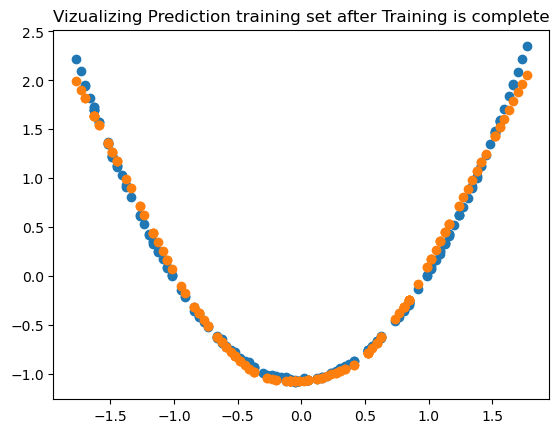

In [37]:
x_values= torch.Tensor.cpu(torch.concat(x_values_for_last_batch))
y_values = torch.Tensor.cpu(torch.concat(y_values_for_last_batch))
print(x_values.shape,y_values.shape)
plt.scatter(x,y)
plt.scatter(x_values[:,0],y_values[:,0])
plt.title('Vizualizing Prediction training set after Training is complete')
plt.show()

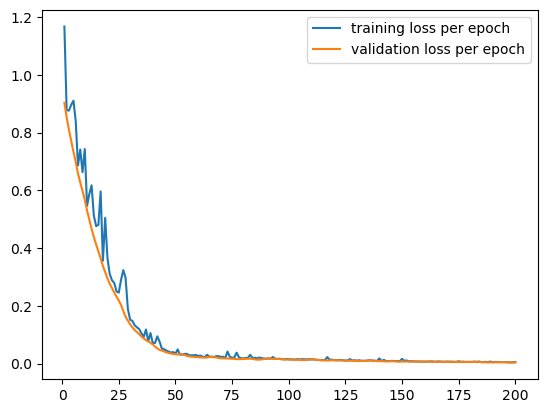

In [38]:
plt.plot(epochs,training_loss_per_epoch,label='training loss per epoch')
plt.plot(epochs,validation_loss_per_epoch,label='validation loss per epoch')
plt.legend()
plt.show()

Graph above shows that we needed just over 50 epochs to complete training

In [39]:
# guessed = []
# def evaluate_model(model,criterion,dataloader):
#     model.eval()

#     with torch.no_grad():
#         for data ,label in dataloader:
#             data = data.to(device)
#             label = label.to(device)
#             outputs = model(data)
#             loss = criterion(outputs,label)
#             guess = (outputs*ydev)+yavg
#             actual = (label*ydev)+yavg
#             print(f'guessed {guess} vs actual {actual} with loss {loss}')
#             guessed.append(outputs)
# evaluate_model(net,criteria,testloader)

In [40]:
torch.save(net.state_dict(),"polynomial.pth")

In [41]:
# net.load_state_dict(torch.load('polynomial.pth'))

# net.eval()

# testing_if_loaded_input = torch.randn(80,1)
# out = net(testing_if_loaded_input)
# print(out)